In [ ]:
#installing intel library for tensorflow
pip install intel-tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.7/244.7 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.2.7 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.


In [ ]:
#enabling intel optimisation for tensorflow
TF_ENABLE_ONEDNN_OPTS=0

In [ ]:
#importing necessary libraries
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from google.colab import files
import pickle
import pydrive

In [ ]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
# Converting grayscale to RGB
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)

In [ ]:
# Resizing images to a smaller size
target_size = (32, 32)
x_train_resized = np.array([img_to_array(array_to_img(img).resize(target_size)) for img in x_train_rgb])
x_test_resized = np.array([img_to_array(array_to_img(img).resize(target_size)) for img in x_test_rgb])


In [ ]:
# Preprocessing input and convert labels to categorical
x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
# Creating a data augmentation generator
datagen = ImageDataGenerator(
    rotation_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)


In [ ]:
# Fitting the data augmentation generator to the training data
datagen.fit(x_train_preprocessed)


In [ ]:
vgg19_model = Sequential()
#obtaining vgg19 from keras library
pretrained_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=None,
    classifier_activation="softmax",
)

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
#native vgg19 model
pretrained_model.summary()
for layer in pretrained_model.layers:
    layer.trainable = True

vgg19_model.add(pretrained_model)
vgg19_model.add(Flatten())
#adding our own dense layers
vgg19_model.add(Dense(512, activation='relu'))
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(10, activation='softmax'))
vgg19_model.summary() #after our additional layers

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Compiling and train the model
vgg19_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 30
batch_size = 64
history = vgg19_model.fit(
    datagen.flow(x_train_preprocessed, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test_preprocessed, y_test)
)

Epoch 1/30
938/938 [==============================] - 78s 65ms/step - loss: 0.7504 - accuracy: 0.7554 - val_loss: 0.4525 - val_accuracy: 0.8385
Epoch 2/30
938/938 [==============================] - 57s 61ms/step - loss: 0.4016 - accuracy: 0.8530 - val_loss: 0.4370 - val_accuracy: 0.8429
Epoch 3/30
938/938 [==============================] - 57s 61ms/step - loss: 0.3524 - accuracy: 0.8697 - val_loss: 0.3679 - val_accuracy: 0.8675
Epoch 4/30
938/938 [==============================] - 58s 62ms/step - loss: 0.3217 - accuracy: 0.8822 - val_loss: 0.3239 - val_accuracy: 0.8831
Epoch 5/30
938/938 [==============================] - 58s 62ms/step - loss: 0.3068 - accuracy: 0.8868 - val_loss: 0.3440 - val_accuracy: 0.8749
Epoch 6/30
938/938 [==============================] - 55s 59ms/step - loss: 0.2824 - accuracy: 0.8958 - val_loss: 0.2844 - val_accuracy: 0.8932
Epoch 7/30
938/938 [==============================] - 55s 58ms/step - loss: 0.2751 - accuracy: 0.8993 - val_loss: 0.2893 - val_accuracy:

In [ ]:
#calculating the overall testing accuracy
vgg19_model.evaluate(x_test_preprocessed, y_test)


313/313 [==============================] - 3s 10ms/step - loss: 0.2404 - accuracy: 0.9192


[0.24035628139972687, 0.9192000031471252]

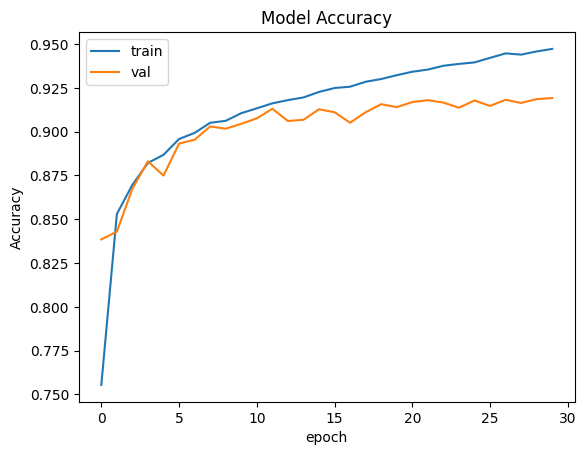

In [ ]:
# Accuracy vs Epoch plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

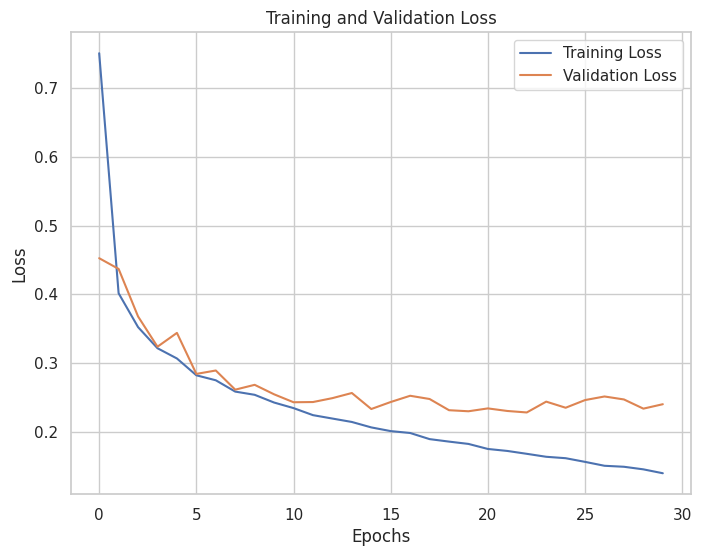

In [ ]:
# Plot training and validation loss
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 [==============================] - 3s 9ms/step


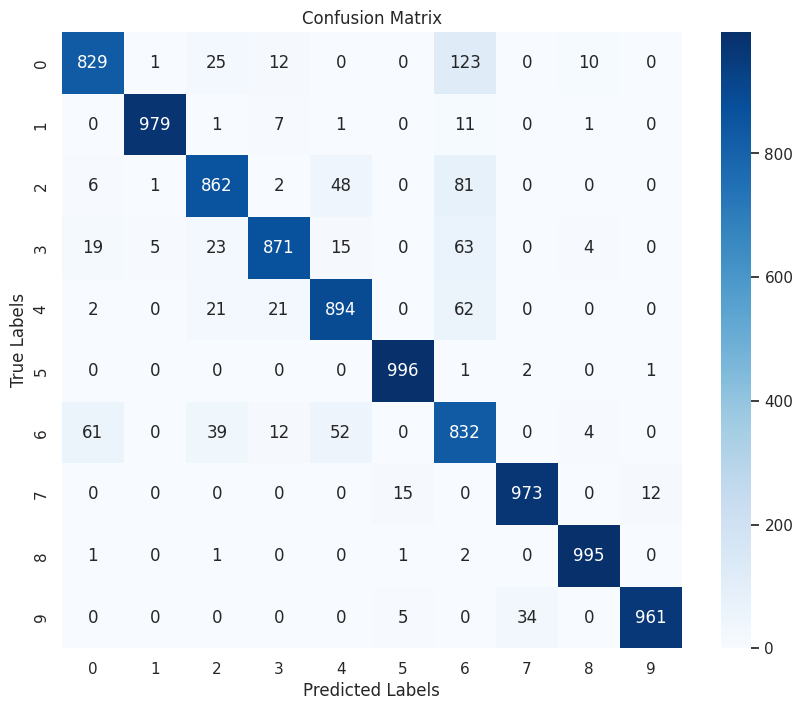

In [ ]:

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(vgg19_model.predict(x_test_preprocessed), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 389ms/step


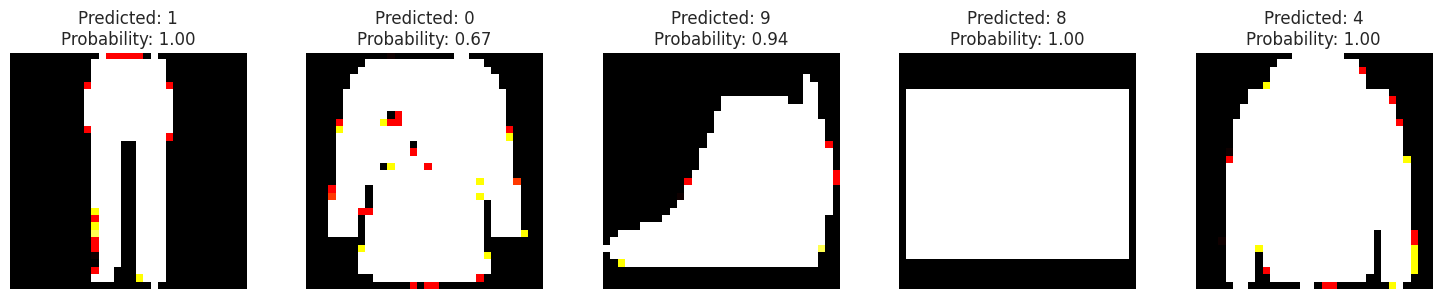

In [ ]:
# Testing with random test samples
num_samples = 5
random_indices = np.random.choice(len(x_test_preprocessed), num_samples, replace=False)
x_samples = x_test_preprocessed[random_indices]
y_true_samples = y_test[random_indices]

# Make predictions
y_pred_samples = vgg19_model.predict(x_samples)
predicted_labels = np.argmax(y_pred_samples, axis=1)
probabilities = np.max(y_pred_samples, axis=1)

# Visualize the samples and predictions
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(x_samples[i])
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {predicted_labels[i]}\nProbability: {probabilities[i]:.2f}")

plt.tight_layout()
plt.show()

In [ ]:
# Printing the class labels
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

Class 0: T-shirt/top
Class 1: Trouser
Class 2: Pullover
Class 3: Dress
Class 4: Coat
Class 5: Sandal
Class 6: Shirt
Class 7: Sneaker
Class 8: Bag
Class 9: Ankle boot


In [ ]:

# Start the timer.
start_time = time.time()

# Running the inference on the VGG19 model for each image.
x_test_preprocessed1 = np.expand_dims(x_test_preprocessed, axis=0) # Add a batch dimension to the input images.
for image in x_test_preprocessed1 :
    prediction = vgg19_model.predict(image)

# Stopping the timer.
end_time = time.time()

# Calculateing  average inference latency.
average_latency = (end_time - start_time) / len(x_test_preprocessed1)

print("Average inference latency: {} milliseconds".format(average_latency))


313/313 [==============================] - 3s 9ms/step
Average inference latency: 5.43909764289856 milliseconds


In [ ]:

# Saving the model using pickle
with open('vgg19.pkl', 'wb') as f:
    pickle.dump(vgg19_model, f)



In [ ]:
#downloading the model
files.download('vgg19.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>